In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
import torch.nn as nn
import importlib

In [2]:
import koopomics as ko

In [3]:
# Load Dataset
pregnancy_df = pd.read_csv('/Users/daviddornig/Documents/Master_Thesis/Bioinf/Code/philipp-trinh/KOOPOMICS/input_data/pregnancy/pregnancy_interpolated_264M_robust_minmax_scaled_outlrem_uniform.csv')

condition_id = 'Condition'
time_id = 'Gestational age (GA)/weeks'
replicate_id = 'Subject ID'
feature_list = pregnancy_df.columns[7:]
num_features = len(feature_list)

train_set_df = pregnancy_df[pregnancy_df['Cohort'] == 'Discovery'].copy()
test_set_df = pregnancy_df[pregnancy_df['Cohort'] == 'Validation (Test Set 1)'].copy()
train_dataloader = ko.OmicsDataloader(train_set_df, feature_list, replicate_id, time_id, 
                                      batch_size=5, max_Ksteps = 10)
test_dataloader = ko.OmicsDataloader(test_set_df, feature_list, replicate_id, time_id, 
                                     batch_size=5, max_Ksteps = 10)


In [4]:
# Load Model
embedding_model = ko.FF_AE([264,1000,1000,10], [10,1000,1000,264],E_dropout_rates= [0,0,0,0],activation_fn='tanh')
operator_model = ko.InvKoop(latent_dim=10, reg='nondelay')

#operator_model = mo.LinearizingKoop(linearizer=mo.FFLinearizer([60,1000,1000,60], [60,1000,1000,60], linE_dropout_rates=[0,0,0,0],activation_fn='tanh'), koop=mo.InvKoop(latent_dim=60, reg='nondelay'))

TestingKoopnondelay = ko.KoopmanModel(embedding=embedding_model, operator=operator_model)


Model loaded with:
FF_AE module
InvKoop module
An invertible Koop


In [5]:
TestingKoopnondelay

KoopmanModel(
  (embedding): FF_AE(
    (encode): Sequential(
      (0): Linear(in_features=264, out_features=1000, bias=True)
      (1): Tanh()
      (2): Linear(in_features=1000, out_features=1000, bias=True)
      (3): Tanh()
      (4): Linear(in_features=1000, out_features=10, bias=True)
    )
    (decode): Sequential(
      (0): Linear(in_features=10, out_features=1000, bias=True)
      (1): Tanh()
      (2): Linear(in_features=1000, out_features=1000, bias=True)
      (3): Tanh()
      (4): Linear(in_features=1000, out_features=264, bias=True)
    )
  )
  (operator): InvKoop(
    (nondelay_fwd): dynamicsC(
      (dynamics): Linear(in_features=10, out_features=10, bias=False)
      (fixed): Linear(in_features=10, out_features=9, bias=False)
      (flexi): Linear(in_features=10, out_features=1, bias=False)
    )
    (nondelay_bwd): dynamics_backD(
      (dynamics): Linear(in_features=10, out_features=10, bias=False)
      (fixed): Linear(in_features=10, out_features=9, bias=False)


In [19]:
def recursive_reload():
    import importlib
    import sys
    
    importlib.reload(ko.training.data_loader)
    importlib.reload(ko.training.train_utils)
    importlib.reload(ko.test.test_utils)
    importlib.reload(ko.model.build_nn_functions)
    importlib.reload(ko.model.embeddingANN)
    importlib.reload(ko.model.koopmanANN)
    importlib.reload(ko.model.model_loader)
    
    importlib.reload(ko.all_functions)
    
    importlib.reload(ko)



In [21]:
recursive_reload()

In [22]:

# Run training loop
ko.train(TestingKoopnondelay, train_dataloader, test_dataloader,
         lr= 0.001, learning_rate_change=0.8, loss_weights=[1,1,1,1,0.001,0],
         num_epochs=300, decayEpochs=[3, 6, 9, 12, 15, 18, 21, 24, 27],
         weight_decay=0, gradclip=1, max_Kstep=10, mask_value=-2,
         print_batch_info=False, model_name='TestingKoop264M_tanh_nondelay')


Using the CPU
----------Training epoch--------
----------------0---------------
hello4
Training interrupted. Saving model...


In [10]:
TestingKoopnondelay.operator.nondelay_bwd.flexi.weight.data

tensor([[ 0.0214,  0.0700,  0.0715,  0.0802,  0.0527,  0.0803,  0.0878,  0.0557,
          0.0676,  0.0670,  0.0493,  0.0387,  0.0544,  0.0618,  0.0341,  0.0328,
          0.0383,  0.0070, -0.0013,  0.0213,  0.0069, -0.0084,  0.0140, -0.0011,
         -0.0013,  0.0021, -0.0110,  0.0311,  0.0283,  0.0033,  0.0430,  0.0083,
          0.0229,  0.0450,  0.0352,  0.0341,  0.0390,  0.0019, -0.0043,  0.0017,
         -0.0120, -0.0359, -0.0379, -0.0304, -0.0429, -0.0284, -0.0361, -0.0657,
         -0.0620, -0.0755, -0.0806, -0.0898, -0.1056, -0.1144, -0.0984, -0.1000,
         -0.0943, -0.0817, -0.1003,  0.8776]])

In [11]:
bwdmatrix,fwdmatrix = TestingKoopnondelay.kmatrix()
bwdM = bwdmatrix.detach()
fwdM = fwdmatrix.detach()
#fwdinv = np.linalg.inv(fwdM)

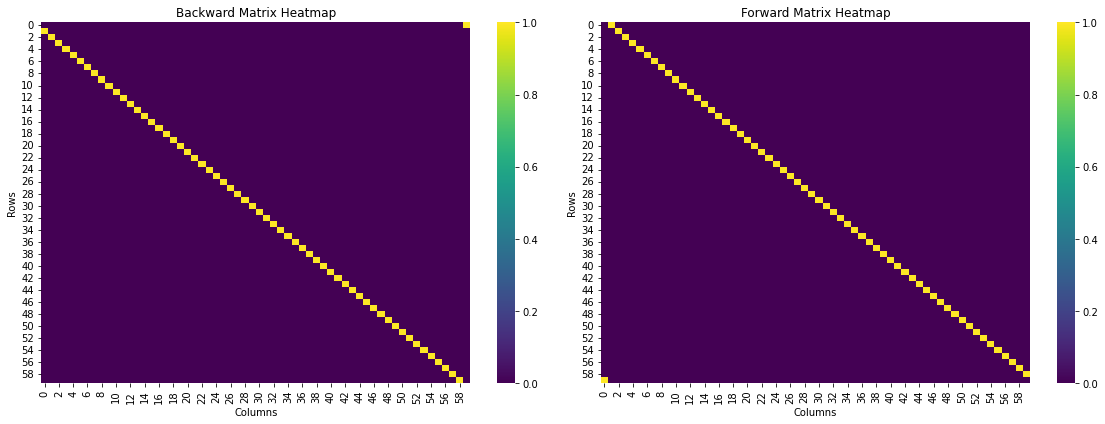

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# First heatmap (for bwdM)
sns.heatmap(bwdM, annot=False, fmt=".2f", cmap='viridis', ax=ax1)
ax1.set_title('Backward Matrix Heatmap')
ax1.set_xlabel('Columns')
ax1.set_ylabel('Rows')

# Second heatmap (for fwdM)
sns.heatmap(fwdM, annot=False, fmt=".2f", cmap='viridis', ax=ax2)
ax2.set_title('Forward Matrix Heatmap')
ax2.set_xlabel('Columns')
ax2.set_ylabel('Rows')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the subplots
plt.show()


In [13]:
nondelay = mo.koopmanANN.dynamicsC(10)

In [14]:
nondelay.fixed.weight.data

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [15]:
nondelay.flexi.weight.data

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
import torch.nn.init as init

init.normal_(nondelay.flexi.weight) 


In [ ]:
torch.cat((nondelay.fixed.weight.data, nondelay.flexi.weight.data),0)